In [1]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

# Text Analysis

So far, we've used Python methods and regular expressions to clean short
text fields and strings.
In this section, we analyze entire documents using a technique called
*text mining*, which transforms free-form text into 
a quantitative representation
to uncover meaningful patterns and insights.

Text mining is a deep topic. Instead of a comprehensive treatment, we
introduce a few key ideas through an example, where
we analyze the State of the Union speeches from 1790 to 2022. 
Every year, the US president gives a State of the Union speech to Congress.
These speeches talk about current events in the country and
make recommendations for Congress to consider.
[The American Presidency Project](https://www.presidency.ucsb.edu/) makes these speeches available online.

Let's begin by opening the file that has all of the speeches:

In [2]:
from pathlib import Path

text = Path('data/stateoftheunion1790-2022.txt').read_text()

At the beginning of this chapter, we saw that each speech in the data begins with 
a line with three asterisks: `***`.
We can use a regular expression to count the number of times the
string `***` appears:

In [3]:
import re
num_speeches = len(re.findall(r"\*\*\*", text))
print(f'There are {num_speeches} speeches total')

There are 232 speeches total


In text analysis, a *document* refers to a single piece of text that we want
to analyze. Here, each speech is a document.
We split apart the `text` variable into its individual documents:

In [4]:
records = text.split("***")

Then we can put the speeches into a dataframe:

In [5]:
def extract_parts(speech):
    speech = speech.strip().split('\n')[1:]
    [name, date, *lines] = speech
    body = '\n'.join(lines).strip()
    return [name, date, body]

def read_speeches():
    return pd.DataFrame([extract_parts(l) for l in records[1:]],
                        columns = ["name", "date", "text"])

df = read_speeches()
df

,name,date,text
0,George Washington,"January 8, 1790",Fellow-Citizens of the Senate and House of Rep...
1,George Washington,"December 8, 1790",Fellow-Citizens of the Senate and House of Rep...
2,George Washington,"October 25, 1791",Fellow-Citizens of the Senate and House of Rep...
...,...,...,...
229,Donald J. Trump,"February 4, 2020",Thank you very much. Thank you. Thank you very...
230,"Joseph R. Biden, Jr.","April 28, 2021",Thank you. Thank you. Thank you. Good to be ba...
231,"Joseph R. Biden, Jr.","March 1, 2022","Madam Speaker, Madam Vice President, our First..."


Now that we have the speeches loaded into a data frame, we want to transform the speeches to see how they have changed over time.
Our basic idea is to look at the words in the speeches---if two speeches
contain very different words, our analysis should tell us that.
With some kind of measure of document similarity, we can see how the speeches differ from one another.

There are a few problems in the documents that we need to take care of first:

* Capitalization shouldn't matter: `Citizens` and `citizens` should be
   considered the same word. We can address this by lowercasing the text.
* There are unspoken remarks in the text: `[laughter]` points out where the
   audience laughed, but these shouldn't count as part of the speech.
   We can address this by using a regex to remove text within
   brackets: `\[[^\]]+\]`. Remember that `\[` and `\]` match
   the literal left and right brackets, and `[^\]]` matches any character that
   isn't a right bracket.
* We should take out characters that aren't letters or whitespace: some 
   speeches talk about finances, but a dollar amount shouldn't count as
   a word. We can use the regex `[^a-z\s]` to remove these characters.
   This regex matches any character that isn't a lowercase letter
   (`a-z`) or a whitespace character (`\s`).

In [6]:
def clean_text(df):
    bracket_re = re.compile(r'\[[^\]]+\]')
    not_a_word_re = re.compile(r'[^a-z\s]')
    cleaned = (df['text'].str.lower()
               .str.replace(bracket_re, '', regex=True)
               .str.replace(not_a_word_re, ' ', regex=True))
    return df.assign(text=cleaned)

df = (read_speeches()
      .pipe(clean_text))
df

,name,date,text
0,George Washington,"January 8, 1790",fellow citizens of the senate and house of rep...
1,George Washington,"December 8, 1790",fellow citizens of the senate and house of rep...
2,George Washington,"October 25, 1791",fellow citizens of the senate and house of rep...
...,...,...,...
229,Donald J. Trump,"February 4, 2020",thank you very much thank you thank you very...
230,"Joseph R. Biden, Jr.","April 28, 2021",thank you thank you thank you good to be ba...
231,"Joseph R. Biden, Jr.","March 1, 2022",madam speaker madam vice president our first...


Next, we look at some more complex issues:

* *Stop words* like `is`, `and`, `the`, and `but` appear so often that we
   would like to just remove them.
* `argue` and `arguing` should count as the same word,
   even though they appear differently in the text. To address this,
   we'll use *word stemming*, which transforms both words to `argu`.

To handle these issues, we can use built-in methods from [the `nltk` library][nltk].

[nltk]: https://www.nltk.org/

Finally, we transform the speeches into *word vectors*.
A word vector represents a document using a vector of numbers.
For example, one basic type of word vector counts up how many times
each word appears in the text, as depicted in
{numref}`Figure %s <fig:word-vectors>`.

```{figure} figures/word-vectors.svg
---
name: fig:word-vectors
---

Bag-of-words vectors for three small example documents
```

This simple transform is called _bag-of-words_, and we apply it on all of our speeches. 
Then we calculate the *term frequency-inverse document frequency* (_tf-idf_ for short) to
normalize the counts and measure the rareness of a word.
The tf-idf puts more weight on words that only appear in a few documents.
The idea is that if just a few documents mention the word _sanction_, say, then
this word is extra useful for distinguishing documents from each other.
[The `scikit-learn` library][sklearn] has a complete
description of the transform and an implementation, which we use.

[sklearn]: https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting

After applying these transforms, we have a two-dimensional array
`speech_vectors`. Each row of this array is one speech transformed into a 
vector:

In [7]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

stop_words = set(nltk.corpus.stopwords.words('english'))
porter_stemmer = PorterStemmer()

def stemming_tokenizer(document):
    return [porter_stemmer.stem(word)
            for word in nltk.word_tokenize(document)
            if word not in stop_words]

tfidf = TfidfVectorizer(tokenizer=stemming_tokenizer)
speech_vectors = tfidf.fit_transform(df['text'])

[nltk_data] Downloading package stopwords to /Users/sam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/Users/sam/mambaforge/envs/textbook-test2/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [8]:
speech_vectors.shape

(232, 13211)

We have 232 speeches, and each speech was transformed into a
length-13,211 vector.
To visualize these speeches, we use a technique called
*principal component analysis* to represent the data table of 13211 features
by a new set of features that are orthogonal to one another. The first vector accounts for 
the maximum variation in the original features, the second for the maximum variance that is orthogonal to the first, and so on.
Often the first two components, which we can plot as pairs of points, reveal clusters and outliers.

Next, we plot the first two principal components. Each point is one speech, and we've colored the points
according to the year of the speech.
Points that are close together represent similar speeches, and
points that are far away from one another represent dissimilar speeches:

In [9]:
from scipy.sparse.linalg import svds

def compute_pcs(data, k):
    centered = data - data.mean(axis=0)
    U, s, Vt = svds(centered, k=k)
    return U @ np.diag(s)

# Setting the random seed doesn't affect svds(), so re-running this code
# might flip the points along the x or y-axes.
pcs = compute_pcs(speech_vectors, k=2)

# So we use a hack: we make sure the first row's PCs are both positive to get
# the same plot each time.
if pcs[0, 0] < 0:
    pcs[:, 0] *= -1
if pcs[0, 1] < 0:
    pcs[:, 1] *= -1

with_pcs1 = df.assign(year=df['date'].str[-4:].astype(int),
                      pc1=pcs[:, 0], pc2=pcs[:, 1])

In [18]:
fig = px.scatter(with_pcs1, x='pc1', y='pc2', color='year',
           hover_data=['name'],
           width=550, height=350)
fig.update_layout(coloraxis_colorbar_thickness=15,
                  coloraxis_colorbar_title='Year')
fig.write_image('figures/sotu_pca.png')

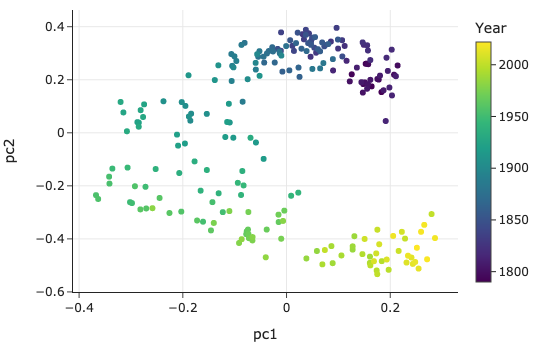

In [19]:
# The colorbar for the above doesn't render in the PDF properly, so we save the
# plot to a file.
from IPython.display import display, Image
display(Image(filename='figures/sotu_pca.png'))

We see a clear difference in speeches over time---speeches given in the 1800s
used very different words than speeches given after 2000.
It's also interesting to see that the speeches cluster tightly in the same
time period.
This suggests that speeches within the same period
sound relatively similar, even though the speakers were from
different political parties.

This section gave a whirlwind introduction to text analysis.
We used text manipulation tools from previous sections to clean up the
presidential speeches.
Then we used more advanced techniques like stemming,
the tf-idf transform, and principal component analysis to compare speeches.
Although we don't have enough space in this book
to cover all of these techniques in detail, we hope that this section
piqued your interest in the exciting world of text analysis.